### Regression Models

Machine Learning에서 Regression은 주된 분야가 아니다. Model 자체가 분류를 목적으로 만들어졌기 때문이다. 그 중 대표적인 Regression Model에 대한 개념들을 살펴보는 것으로 한다

#### 1. Bias - Variance Dilemma

다음 회귀모형을 고려해 보자

$$y_t = \beta_0 + \beta_1 x_t + \epsilon_t, ~~~~~ \epsilon_t \sim N(0,\sigma_\epsilon^2) $$

오차항은 다음과 같이 다시 쓸 수 있다

$$\epsilon_t = y_t - \hat{\beta_0} - \hat \beta_1 x_t$$

이를 제곱한 값을 Mean Squared Error라고 하는데, MSE는 다음과 같이 분해할 수 있다

$$\mathrm{MSE} = (E[\beta_0 + \beta_1 x_t - \hat \beta_0 - \hat \beta_1 x_t])^2 + \mathrm{Var}(\hat\beta_0 + \hat\beta_1 x_t) + \sigma_\epsilon^2$$

여기서 $E[\beta_0 + \beta_1 x_t - \hat \beta_0 - \hat \beta_1 x_t])^2$는 편향이라고 하고, $\mathrm{Var}(\hat\beta_0 + \hat\beta_1 x_t)$는 분산이라고 한다. $\sigma_\epsilon^2$은 줄일 수 없는 순수한 데이터의 잡음이다

즉, MSE optimization 과정에서 Variance와 Bias의 tradeoff 관계가 존재한다는 것을 유추할 수 있다. 이를 두고 계량경제학과 머신러닝 모형의 목적이 확연히 구분된다

- 계량경제학의 목적 : unbiased estimator중에서 Variance를 최소화하는 값을 추정한다 (BLUE, MVUE)
- 머신러닝의 목적 : **성능을 최대화하는** 지점에서 Bias와 Variance를 **적절히 조정한다** (minimize MSE)

Machine Learning에서는 Bias에 대한 엄격한 가정 **(BLUE, 최소제곱불편추정량)** 을 포기하고, 분산을 최소화하여 예측력을 높이는 것을 목표로 한다. 이 관점에서 기존의 계량경제학과 충돌이 발생한다. Machine Learning에서 추정된 coefficient는 bias를 포함하기 때문에, coefficient는 해석에 있어서 어려움이 있다. 다만, 예측력은 기존 계량경제학 모형에 비해 월등히 좋다.

#### example 1

CAPM 모형을 이용하여 계량경제학 모형과 Machine Learning 모형의 추정 결과를 비교해 보자

In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr

start_date = pd.to_datetime('2015-01-01')
end_date = pd.to_datetime('2023-10-31')

hynics = pdr.DataReader("000660", "naver", start_date, end_date).astype(int)
hynics.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-01-02,47950,48400,47650,47750,1155944
2015-01-05,48050,48400,47500,47650,1409146
2015-01-06,47000,47600,46900,47500,1661196
2015-01-07,46700,47600,46700,47400,1821266
2015-01-08,48250,50000,47900,49950,5006675


In [2]:
kospi = pdr.DataReader('KOSPI', "naver", start_date, end_date).astype(float)
kospi.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-01-02,1914.24,1929.15,1909.67,1926.44,258775.0
2015-01-05,1921.96,1921.96,1903.37,1915.75,313442.0
2015-01-06,1895.48,1900.02,1877.38,1882.45,303687.0
2015-01-07,1878.90,1887.60,1876.27,1883.83,280509.0
2015-01-08,1895.85,1907.23,1891.77,1904.65,262207.0


In [3]:
monthly_hynics = hynics.resample('W').last()
kospi_mon = kospi.resample('W').last()

ret_hynics = np.log(monthly_hynics.Close) - np.log(monthly_hynics.Close.shift(1))
ret_kospi = np.log(kospi_mon.Close) - np.log(kospi_mon.Close.shift(1))

matrix = pd.concat([ret_hynics, ret_kospi], axis = 1).dropna()
matrix.columns = ['Hynics','KOSPI']

matrix.head()

,Hynics,KOSPI
Date,,
2015-01-11,0.040026,-0.000904
2015-01-18,-0.046328,-0.019183
2015-01-25,0.001053,0.025084
2015-02-01,0.003153,0.006779
2015-02-08,-0.046170,0.003206


SK hynics 주별 데이터와 KOSPI 시장 수익률 데이터를 가지고 온다. 우선 전통적인 계량 모형의 추정 결과부터 살펴 보자

In [4]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X = matrix['KOSPI'] - 0.03
X = sm.add_constant(X)
y = matrix['Hynics']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)

model = sm.OLS(y_train, X_train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 Hynics   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                     179.1
Date:                Thu, 09 Nov 2023   Prob (F-statistic):           1.63e-33
Time:                        12:41:02   Log-Likelihood:                 673.98
No. Observations:                 367   AIC:                            -1344.
Df Residuals:                     365   BIC:                            -1336.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0357      0.003     11.147      0.0

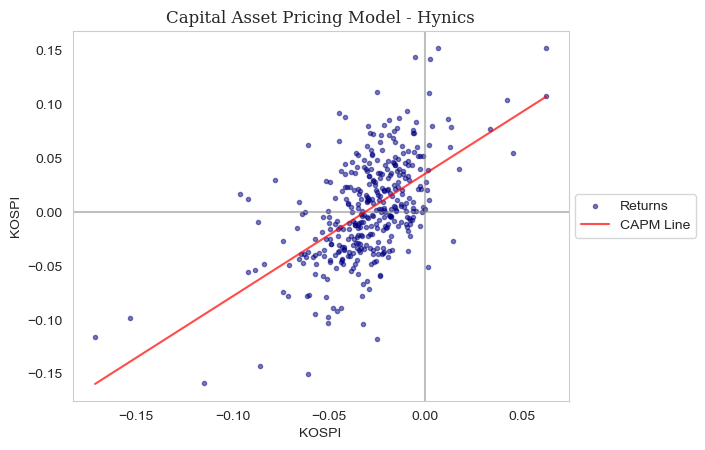

In [5]:
import seaborn as sns
beta, alpha = np.polyfit(x = X_train['KOSPI'] , y = y_train ,deg = 1)
plt.axvline(0, color = 'grey', alpha = 0.5)
plt.axhline(0, color = 'grey', alpha = 0.5)
plt.scatter(X_train['KOSPI'], y_train, label = 'Returns', marker = '.', color = 'navy', alpha = 0.5)
sns.lineplot(x = X_train['KOSPI'], y = alpha + X_train['KOSPI'] * beta, color = 'red', label = 'CAPM Line', alpha = 0.7)
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.grid(False)
plt.title('Capital Asset Pricing Model - Hynics', fontfamily = 'Serif')
plt.show()

추정된 회귀선은 위와 같이 출력된다. 추정된 결과는 최소 분산은 아닐수도 있지만 불편 추정량이다

In [6]:
print('The estimated Beta is %.4f' % result.params[1])

The estimated Beta is 1.1398


추정된 Coefficient는 위와 같다. 그렇다면, test 기간에 대해서는 어떻게 될까?

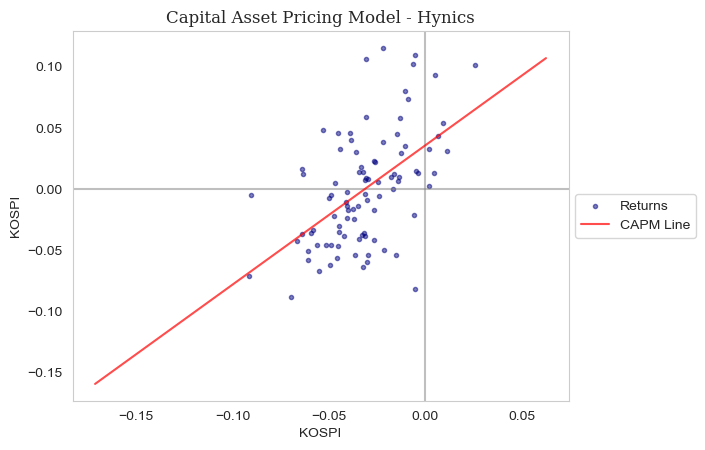

In [7]:
beta, alpha = np.polyfit(x = X_train['KOSPI'] , y = y_train ,deg = 1)
plt.axvline(0, color = 'grey', alpha = 0.5)
plt.axhline(0, color = 'grey', alpha = 0.5)
plt.scatter(X_test['KOSPI'], y_test, label = 'Returns', marker = '.', color = 'navy', alpha = 0.5)
sns.lineplot(x = X_train['KOSPI'], y = alpha + X_train['KOSPI'] * beta, color = 'red', label = 'CAPM Line', alpha = 0.7)
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.grid(False)
plt.title('Capital Asset Pricing Model - Hynics', fontfamily = 'Serif')
plt.show()

In [8]:
from sklearn.metrics import mean_squared_error, r2_score
y_pred = result.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R squared score: {r2}")

Mean Squared Error: 0.001531790710522154
R squared score: 0.27855973222058583


test 기간에 대해서도 MSE가 0.0015318정도로 꽤 준수한 성능을 보여준다. 이번에는 panelized Regression model인 Ridge Regression의 경우를 살펴보자

In [9]:
from sklearn.linear_model import Ridge

linear = Ridge(alpha = 0.0001)
linear.fit(X_train, y_train)

Ridge(alpha=0.0001)

sklearn에서 Linear Model들은 coef_ 속성을 통해 추정된 회귀계수를 볼 수 있다

In [10]:
print(linear.coef_)

[0.         1.13922681]


In [11]:
y_pred_linear = linear.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print(f"Ridge Regression - MSE: {mse_linear}, R-squared: {r2_linear}")

Ridge Regression - MSE: 0.001531779911164356, R-squared: 0.2785648184843478


sklearn의 Ridge Regression이 예측에 대해 MSE가 조금 더 줄은 것을 확인할 수 있다. 그러나, 통계학적으로 추정된 coefficient는 **unbiased Estimator** 가 아니다

게다가, sklearn의 Linear Model에서는 $\beta_0$에 해당하는 intercept도 추정되지 않는다

#### 2. Support Vector Regression

1995년, Vapnik와 Cortes는 Support Vector Network라는 모형을 제안하였다

```
sklearn.svm.SVR(*, kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)
```

주요 Hyper Parameter는 다음과 같다

- kernel : SVM 커널 함수를 지정한다
- degree : kernel을 poly, 즉 비선형으로 지정하였을 때 지정하는 차수이다. 기본값은 3이며 값이 커질수록 모형이 복잡해진다
- coef0 : y intercept를 지정한다
- C : L2 score (Ridge)를 비용함수로 지정한다. 값이 작아질수록 일반화 성능이 커진다. 기본값은 1이다


https://link.springer.com/article/10.1007/BF00994018

**2.1 Hard Margin Model**

Hard Margin Model의 손실함수는 다음을 최적화하는 것을 목적으로 한다

$$\mathrm{Loss_{SVR}} = \min_w ||w||^2 + \lambda(\frac{1}{2}\sum_{i = 1}^n (y_i - f(x_i))^2)$$

여기서 $||w||^2$는 데이터와 회귀선과의 거리를 나타내는데, 이는 선형회귀식에서 오차를 최소화하는 식과 유사함을 알 수 있다.

#### example 2

example 1의 모형을 Hard Margin SVR 모형에 적합화해 보자

In [12]:
from sklearn.svm import SVR

X = matrix['KOSPI'] - 0.03
X = sm.add_constant(X)
y = matrix['Hynics']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)

model = SVR(kernel = 'linear', C = 1000)
model.fit(X_train, y_train)

SVR(C=1000, kernel='linear')

C가 클 수록 Train Data에 적합화된다. 즉, Hard Margin Model로 추정된다

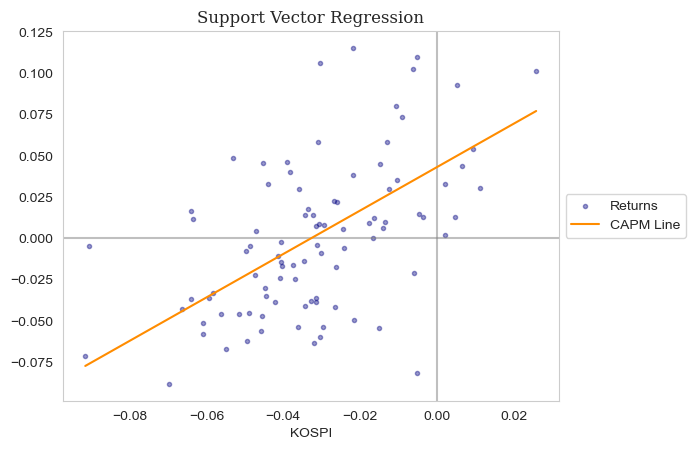

In [13]:
y_pred = model.predict(X_test)

beta, alpha = np.polyfit(x = X_train['KOSPI'] , y = y_train ,deg = 1)
plt.axvline(0, color = 'grey', alpha = 0.5)
plt.axhline(0, color = 'grey', alpha = 0.5)
plt.scatter(X_test['KOSPI'], y_test, label = 'Returns', marker = '.', color = 'navy', alpha = 0.4)
sns.lineplot(x = X_test['KOSPI'], y = y_pred, color = 'darkorange', label = 'CAPM Line')
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.grid(False)
plt.title('Support Vector Regression', fontfamily = 'Serif')
plt.show()

coefficient가 추정되긴 하지만, 여타 ML 모형과 마찬가지로 unbiased estimator가 아니니 해석에 유의해야 한다

In [14]:
model.coef_

array([[4.54747351e-13, 1.31661564e+00]])

**2.2 Soft Margin Model**

<center><img src = "https://leejiyoon52.github.io/images/image_67.png" alt="My Image"></center>

과적합이나 기타 일반화 성능 향상을 위해, 보통은 아래와 같은 손실함수를 최적화하는 것을 목적으로 한다

$$\mathrm{Loss_{SVR}} = \min_w \frac{1}{2}||w||^2 + C\sum_{i = 1}^n (\xi_i + \xi_i^*)$$
$$\mathrm{such~that~} (w^T x_i + b) - y_i \leq \epsilon + \xi_i$$
$$y_i - (w^T x_i + b) \leq \epsilon + \xi_i^*$$
$$\xi_i, \xi_i^* \geq 0$$

추정된 회귀식에서 상단과 하단에 각각 $\epsilon$만큼 마진을 생성하여 추정식의 허용 범위를 넓혀 준다. 즉, margin 값을 크게 줄 수록 모형의 노이즈 허용 범위가 커지는 것이다

비용함수 최적화에 있어서 Lagrangian Problem으로 해를 찾는 것이 가능하지만, 그 과정이 길기 때문에 우선은 생략한다. Lagrangian Dual Problem은 다음과 같이 정리된다

$$\mathbf{L_D} = \frac{1}{2}\sum_{i,j = 1}^n (\alpha_i^* - \alpha_i)(\alpha_j^* - \alpha_j)\mathbf{x_i^Tx_j} - \epsilon \sum_{i,j = 1}^n(\alpha_i^* - \alpha_i) + \sum_{i,j = 1}^n y_i(\alpha_i^* - \alpha_i)$$
$$\mathrm{such ~ that ~} \sum_{i=1}^n (\alpha_i^* - \alpha_i) = 0, ~~~~~ \alpha_i, \alpha_i^* \in [0,C]$$

Lagrangian dual problem으로 재구성한 목적식은 $α$로 이루어져있는 convex하고, 연속적인 quadratic programming problem이다. 최적화 프로그램을 이용한다면 간편하게 $α$를 도출할 수 있다

#### example 3

example 2에 이어 soft margin model을 추정해 보자. 여기서 C = 0.1을 사용하도록 한다

In [15]:
from sklearn.svm import SVR

X = matrix['KOSPI'] - 0.03
X = sm.add_constant(X)
y = matrix['Hynics']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)

model = SVR(kernel = 'linear', C = 0.1)
model.fit(X_train, y_train)

SVR(C=0.1, kernel='linear')

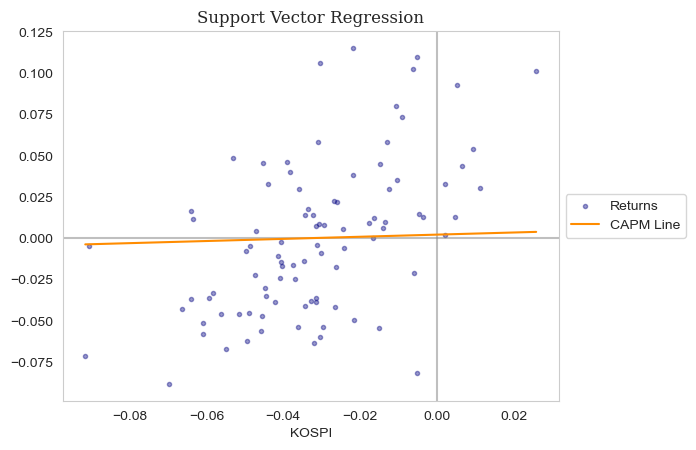

In [16]:
y_pred = model.predict(X_test)

beta, alpha = np.polyfit(x = X_train['KOSPI'] , y = y_train ,deg = 1)
plt.axvline(0, color = 'grey', alpha = 0.5)
plt.axhline(0, color = 'grey', alpha = 0.5)
plt.scatter(X_test['KOSPI'], y_test, label = 'Returns', marker = '.', color = 'navy', alpha = 0.4)
sns.lineplot(x = X_test['KOSPI'], y = y_pred, color = 'darkorange', label = 'CAPM Line')
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.grid(False)
plt.title('Support Vector Regression', fontfamily = 'Serif')
plt.show()

C값을 작게 하면 할수록 추정치는 $\hat y_i = \bar y$에 가까워진다. 즉, 모형이 단순해진다

In [17]:
model.coef_

array([[-2.77555756e-17,  6.45651355e-02]])

마찬가지로 coefficient를 확인할 수 있지만, 큰 의미는 없으므로 무시해도 된다

**2.3 Kernel Function**

Support Vector Machine은 선형 모형이기 때문에 비선형 회귀식을 구해야 하는 경우가 상당히 제약적이었다. 이런 경우 Mapping function의 일종인 Kernel Function을 사용하여 해결하게 되었다

$$x = (x_1, x_2, \dots, x_p) \Rightarrow \phi(x) = z = (z_1, z_2, \dots, z_q)$$

<center><img src = "https://leejiyoon52.github.io/images/image_80.png" alt="My Image"></center>

즉, 중간에 비선형 공간을 추가하여 선형공간으로 다시 데이터를 평평하게 펴는 과정을 거치는 것이라 이해하면 좋다. Kernel Function이 포함된 Lagrangian Dual Problem은 다음과 같이 표현된다

$$\mathcal{L_D} = \frac{1}{2}\sum_{i,j = 1}^n (\alpha_i^* - \alpha_i)(\alpha_j^* - \alpha_j)\mathbf{K(x_i^,x_j)} - \epsilon \sum_{i,j = 1}^n(\alpha_i^* - \alpha_i) + \sum_{i,j = 1}^n y_i(\alpha_i^* - \alpha_i)$$

평면식과는 다르게 중간 과정에서 Kernel Function의 Mapping과정이 포함된것을 알 수 있다

대표적인 kernel function에는 다음과 같은 것들이 있다. 주로 rbf가 자주 사용된다

- linear : 선형 커널
- poly : 비선형 커널, 3차 함수가 기본적으로 추정된다
- rbf(default) : RBF커널, 가우시안 커널이다. 성능이 좋기 때문에 자주 사용된다
- sigmoid : sigmoid 커널
- precomputed

#### 3. Regression Tree

```
sklearn.tree.DecisionTreeRegressor(*, criterion='squared_error', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, ccp_alpha=0.0)
```

Regression Tree는 오차제곱합을 가장 잘 줄일 수 있는 Feature를 기준으로 분기를 만들어 결과를 예측하는 매우 단순한 모형이다. 분기 과정에서 정보가 저장되는데, 이를 이용해 모형 추정 후 어떤 Feature가 예측에 크게 작용했는지 볼 수 있기 때문에 설명력에 있어서 다른 Machine Learning 모형보다 우월하다

최근에는 이를 이용하여 Inference를 시도하는 것이 연구되고 있다. 다만 여기서 유의할 점은, Granger Causality와 같이 예측에 있어서 특정 Feature가 큰 영향을 끼쳤다는 것을 보여줄 뿐, **인과관계를 보장하지는 않는다.** 즉, 여전히 인과관계 추론에 있어서는 **Domain Knowledge**가 매우 중요하다

아래는 Tree Model이 분기를 하는 과정을 보여준다

<center><img src = "https://www.statology.org/wp-content/uploads/2020/11/tree6.png" alt="My Image"></center>

Model자체가 분기를 포함하기 때문에, 추정된 Regression Line은 각이 진 상태로 나온다. 아래는 Regression Tree가 추정한 Line을 보여준다

<center><img src = "https://cdn-images-1.medium.com/max/1200/1*VD-ygoJ8OwUpBaTgkDTSOg.png" alt="My Image"></center>

**3.1 Training**

Regression Tree는 Top-down 방식으로 진행되며, 탐욕적 알고리즘 탐색 방식으로 가장 좋은 가지를 찾아서 분기를 하는 방식을 반복한다. 모든 변수 $X_1, X_2, \dots, X_p$와 모든 가능한 분기지점(cut point) $s$에 대해 오차 제곱합을 가장 많이 줄여주는 $(j,s)$를 선택하게 된다. Tree가 두 개의 분기로 나뉘는 초평면은 다음과 같이 정의 가능하다

$$R_1(j,s) = \{X | X_j < s\} \mathrm{~~and~~} R_2 (j,s) = \{X|X_j \geq s\}$$

다음 수식을 최소화시키는 $j$와 $s$를 구하는 식으로 분기가 이뤄진다

$$\Sigma_{i:x_i \in R_1(j,s)}(y_i - \hat{y_{R_1}})^2 + \Sigma_{i:x_i \in R_2(j,s)}(y_i - \hat{y_{R_2}})^2$$

여기서 목적이 **최소제곱**이라는 것에 주목하자. $R_1, R_2$로 구획을 나눌 때 $R_1(j,s)$에 속한 데이터들과 구획 내의 평균$\hat{y_{R_1}}$와의 차이를 구한 뒤 제곱하고, 이를 $R_2$도 마찬가지로 진행한 뒤 모두 더함으로써 오차 제곱합을 구한다

분기를 한 뒤 오차 제곱합이 분기 전 오차 제곱합보다 작아질 때까지 위 과정을 반복한다

**3.2 Pruning**

가지치기(Pruning)는 Tree Model에서 과적합에 대응하기 위한 주요 수단이다. Tree Regression의 Hyper Parameter로는 크게 Depth와 Node의 수가 있는데, Depth와 Node의 수가 커질수록, 복잡한 모형이 된다

가지치기에는 크게 **사전 가지치기(Pre-pruning)** 와 **사후 가지치기(Post-pruning)** 이 존재한다. 사전 가지치기는 노드 분기 전 일반화 성능을 향상시킬 수 없는 것을 미리 예측하여 만약 성능 향상이 이뤄지지 않는다면, 분기를 중지하고 해당 노드를 마지막으로 학습을 끝내는 방식이다. 사후 가지치기는 모형 학습을 완료한 이후, 일반화 성능을 높이는 분기들을 삭제하는 방식으로 이뤄진다

일반적으로 사전 가지치기가 통계적 오류를 범할 실수가 적으며, 사후 가지치기는 데이터 의존적인 판단방법이 될 수 있다. sklearn에서는  `cost_complexity_pruning_path`, `ccp_alpha`를 이용해 사후 가지치기를 할 수 있으며, 사전 가지치기는 `max_depth`, `min_samples_split`, `min_samples_leaf`를 통해 지정할 수 있다

#### example 4

French 교수는 매년 Factor Model 추정을 위한 데이터를 꾸준히 업데이트 한다. 아래 주소로 가면 전체 데이터를 받아볼 수 있다

https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html

준비된 `factor_data.csv`는 월간 CRSP Data 변화에 따른 3 Factor이다

In [18]:
factor = pd.read_csv('factor_data.csv', index_col = 0)
factor.index = pd.to_datetime(factor.index.astype(str))
factor.head()

,Mkt-RF,SMB,HML,RF
1926-07-02,1.60,-0.62,-0.83,0.056
1926-07-10,0.36,-0.88,0.31,0.056
1926-07-17,1.01,0.59,-1.44,0.056
1926-07-24,-2.05,0.10,-0.18,0.056
1926-07-31,3.04,-1.82,-0.90,0.056


3 factor model은 아래와 같이 추정된다

$$(R_i - R_f)_t = \beta_0 + \beta_1 (R_m - R_f)_t + \beta_2 \mathrm{SMB}_t + \beta_3 \mathrm{HML}_t + \epsilon_t, ~~~~~ \epsilon_t \sim N(0, \sigma_\epsilon^2)$$

여기서 $R_f$는 무위험수익률, $R_i$는 자산 i에 대한 수익률, $R_m$은 시장수익률, $\mathrm{SMB}_t$는 소형주의 평균 수익률, $\mathrm{HML}_t$는 대형주들의 평균 수익률이다

우선, 다중회귀분석을 진행해 보자

In [19]:
import yfinance as yf

start_date = '2000-01-01'
end_date = '2023-11-01'

apple = yf.download('AAPL', start = start_date, end = end_date)
apple.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442,0.848323,535796800
2000-01-04,0.966518,0.987723,0.903460,0.915179,0.776801,512377600
2000-01-05,0.926339,0.987165,0.919643,0.928571,0.788168,778321600
2000-01-06,0.947545,0.955357,0.848214,0.848214,0.719961,767972800
2000-01-07,0.861607,0.901786,0.852679,0.888393,0.754065,460734400


In [20]:
apple = apple.resample('W-Fri').last()
ret_apple = np.log(apple.Close) - np.log(apple.Close.shift(1))

matrix = pd.concat([ret_apple - factor['RF'], factor.iloc[:,:-1]], axis = 1).dropna()
matrix.columns = ['apple', 'market-rf', 'smb', 'hml']

matrix.head()

,apple,market-rf,smb,hml
2000-01-14,-0.093623,2.07,1.96,-1.50
2000-01-21,-0.000193,0.02,6.94,-2.81
2000-01-28,-0.194052,-5.71,0.17,1.75
2000-02-04,-0.047158,4.46,1.26,-2.94
2000-02-11,-0.101080,-1.45,6.24,-2.83


In [21]:
X = matrix.drop('apple', axis = 1)
X = sm.add_constant(X)
y = matrix['apple']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)

model = sm.OLS(y_train, X_train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  apple   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     90.83
Date:                Thu, 09 Nov 2023   Prob (F-statistic):           1.12e-51
Time:                        12:41:05   Log-Likelihood:                 1298.4
No. Observations:                 953   AIC:                            -2589.
Df Residuals:                     949   BIC:                            -2569.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0299      0.002    -14.842      0.0

In [22]:
y_pred = result.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R squared score: {r2}")

Mean Squared Error: 0.002246933018794043
R squared score: 0.2250979351027267


그렇다면, Regression Tree의 추정 결과는 어떻게 나올까?

In [23]:
from sklearn.tree import DecisionTreeRegressor

X = matrix.drop('apple', axis = 1)
X = sm.add_constant(X)
y = matrix['apple']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)

tree = DecisionTreeRegressor(criterion = 'squared_error',
                             max_depth = 3,
                             random_state = 42)

tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3, random_state=42)

Decision Tree에서는 coefficient대신 feature importance를 볼 수 있다. 이 결과를 통해 어떤 Feature가 예측에 있어서 영향을 주었는지 볼 수 있다

In [24]:
tree.feature_importances_

array([0.        , 0.73630803, 0.        , 0.26369197])

예측에 대한 성능은 오히려 계량경제 모델보다 떨어지는 것으로 나타났다. 이는 과적합 규제가 제대로 되지 않았기 때문인 것으로 보인다

In [25]:
y_pred = tree.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R squared score: {r2}")

Mean Squared Error: 0.002999012700096499
R squared score: -0.034272545963658585


#### Exercise 1

임의의 NASDAQ 상장종목에 대해 다음을 수행하라

**1.1** example 4에서 활용한 factor data를 기반으로 statsmodel을 사용해 다중회귀분석을 시행하라

In [26]:
# Write your code here!

**1.2** Ridge Regression을 사용하여 coefficient를 추정하라. 1.1번과 어떤 차이가 있고, 이 추정량은 unbiased estimator인지 설명하라

In [27]:
# Write your code here!

**1.3** SVR을 사용하여 회귀선을 추정하라. 선형모형과 어떤 차이가 있는지 설명하라. 여기서 추정된 coefficient는 신뢰할 수 있는가? 여기서 `C = 10`을 사용한다

In [28]:
# Write your code here!

**1.4** Regression Tree 모형을 사용하여 추정하라. 추정한 모형의 feature importance를 확인하라. 추정된 feature importance는 회귀 계수와 어떤 관계가 있는가?

In [29]:
# Write your code here!

**1.5** 위 Machine Learning 모형의 추정 결과로 선정한 종목이 소형주인지, 대형주인지 추론할 수 있는가? 이유를 들어 설명하라